# Standard Study Validation

Here I will try to validate the rules found here: https://www.notion.so/d3b/Standard-Study-Validation-935bc971bd1141f0a3d76a2a9caca461. 

In [76]:
from collections import Counter, defaultdict
from pprint import pprint
from kf_lib_data_ingest.common.io import read_df

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [77]:
# Load dummy data

def load_csv(path):
    return pd.read_csv(path, dtype=str)

NA = ""

filenames = ['data1/{}.csv'.format(file) for file in 'pf pg sp sg spf sfp2'.split()]

data_files = [read_df(path, encoding="utf-8-sig").replace("NA", NA) for path in filenames]

for filename, data_file in zip(filenames, data_files):
    data_file.name = filename
    
pf, pg, sp, sg, spf, spf2 = data_files

In [103]:
pf

,PARTICIPANT|ID,FAMILY|ID
0,P10,F10
1,P11,
2,,F12
3,P13,F13


In [79]:
pg

,PARTICIPANT|ID,GENOMIC_FILE|URL_LIST
0,P4,['foo/s5.txt']
1,P9,['foo/s9.txt']
2,P10,['foo/s11.txt']


In [80]:
sp

,BIOSPECIMEN|ID,PARTICIPANT|ID
0,S7,P5
1,S10,P6
2,S11,P10


In [81]:
sg

,BIOSPECIMEN|ID,GENOMIC_FILE|URL_LIST
0,S7,['foo/s7.txt']
1,S10,['foo/s10.txt']


In [82]:
spf

,BIOSPECIMEN|ID,PARTICIPANT|ID,FAMILY|ID
0,S1,P1,F1
1,S2,P1,F1
2,S3,P3,F1
3,S4,P3,
4,S5,P4,F2
5,S6,P5,F2
6,S7,,F2
7,S8,,
8,S9,P9,F9


In [83]:
spf2

,BIOSPECIMEN|ID,PARTICIPANT|ID,FAMILY|ID
0,S7,P5,F2
1,,P6,F3
2,S2,P2,F1


In [84]:
def df_to_graph(G, df):
    columns = df.columns.values
    for index, row in df.iterrows():
        row_list = list(row)
        for i, item in enumerate(row_list[:-1]):
            left_node = {
                "type": columns[i],
                "ID": item
            }
            
            right_node = {
                "type": columns[i + 1],
                "ID": row_list[i + 1]
            }
            
            if left_node["ID"] not in G.nodes:
                G.add_node(left_node["ID"])
                G.nodes[left_node["ID"]]["type"] = left_node["type"]
            if right_node["ID"] not in G.nodes:
                G.add_node(right_node["ID"])
                G.nodes[right_node["ID"]]["type"] = right_node["type"]
                
            G.add_edge(left_node["ID"], right_node["ID"])

In [85]:
G = nx.Graph()
for df in data_files:
    df_to_graph(G, df)

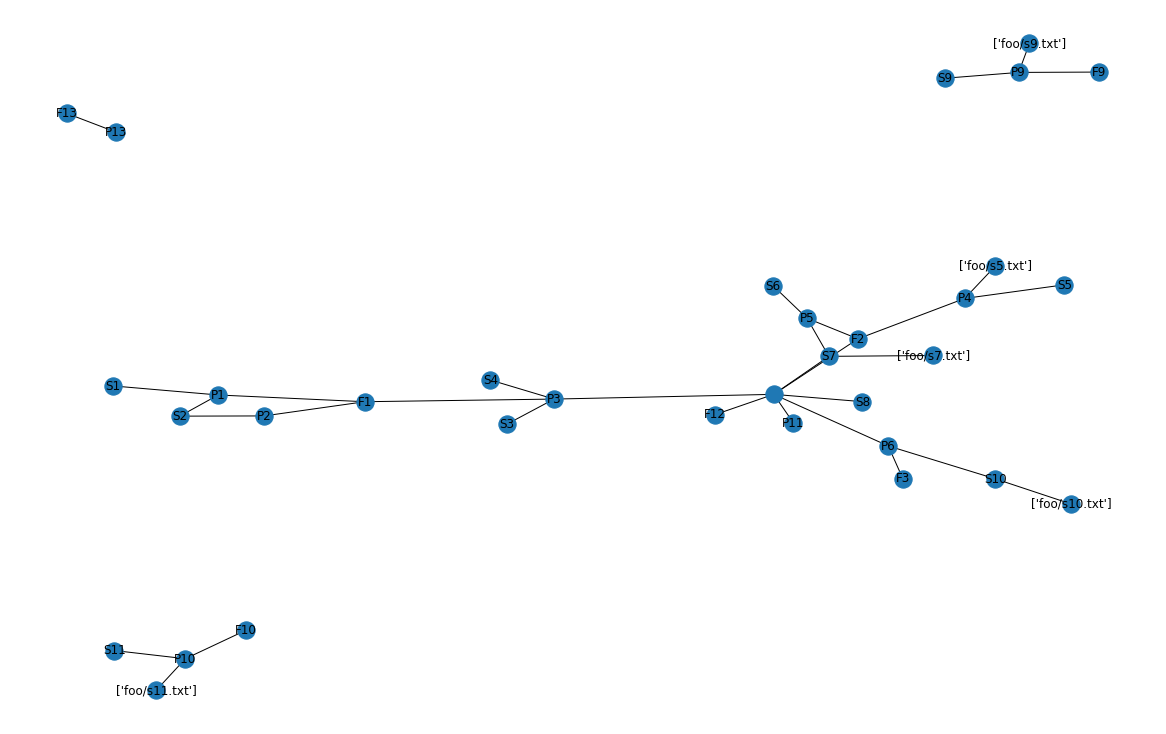

In [86]:
plt.figure(figsize=(16,10))
nx.draw(G, with_labels=True)

So here we have major clumping. This is because patients in the same family are connected, so all their associated biospecimens and files and stuff will get connected as well. When creating the edges we need to make family nodes a special case. Also need to figure out how to handle `nan`s. 

In [87]:
FAMILY_ID = "FAMILY|ID"

class Node(object):
    def __init__(self, node_type, data):
        self.type = node_type
        self.data = data
        self.family = self.type == FAMILY_ID
        self.visible = bool(self.data)
        

In [131]:
participants, biospecimens = [], []

def new_df_to_graph(G, df):
    columns = df.columns.values
    for index, row in df.iterrows():
        row_list = list(row)
        for i, item in enumerate(row_list[:-1]):
            
            left_node = Node(node_type=columns[i], data=item)
            right_node = Node(
                node_type=columns[i + 1],
                data=row_list[i + 1]
            )
            
            for node in (left_node, right_node):
                if node.type == "PARTICIPANT|ID":
                    participants.append(node.data)
                elif node.type == "BIOSPECIMEN|ID":
                    biospecimens.append(node.data)

            if left_node.visible:
                G.add_node(left_node.data, type=left_node.type, file=df.name)
            if right_node.visible:
                G.add_node(right_node.data, type=right_node.type, file=df.name)
                
            if left_node.visible and right_node.visible:
                G.add_edge(left_node.data, right_node.data)

In [108]:
# The graph we've created temporarily is wrong, because including family IDs as nodes leads to a lot of connections
# that we don't want in the end. But it's necessary to get all familyID-participantID links, including those that are
# indirect. We need to store this data in an auxillary data structure, update the participant nodes with their 
# familyID (if they have one) for easy lookup later, then clip the familyID nodes.

# Things get weird if a participant is a member of more than one family (which is allowed). In order
# to handle this, we need to take each connected subcomponent and split them up further into connected
# subcomponents for each family unit. This can be done by iterating over the family ID nodes and deleting
# all other family ID nodes in the subcomponent.

def record_family(G):
    family_dict = {}
    subgraphs = list(nx.connected_components(G))
    for subgraph in subgraphs:
        families, participants = [], []
        # Collect family and participant nodes
        for node in subgraph:
            node_type = G.nodes[node]["type"]
            if node_type == "PARTICIPANT|ID":
                participants.append(node)
            elif node_type == FAMILY_ID:
                families.append(node)
                
        # Iterate over family nodes and create subcomponents representing them individually 
        for familyID in families:
            subG = G.subgraph(subgraph)
            other_fams = list(families)
            other_fams.remove(familyID)
            # Delete the other family ID nodes
            for other_fam in other_fams:
                subG.remove_node(other_fam)
            
            sub_parts = []
            for node in subG.nodes():
                if node in participants:
                    sub_parts.append(node)
                    if "family" not in G.nodes[node]:
                        G.nodes[node]["family"] = []
                    G.nodes[node]["family"].append(familyID)

            family_dict[familyID] = {
                "participants": sub_parts,
                "file": G.nodes[familyID]["file"]
            }
            
        # Finally remove the family nodes in this subgraph from the total graph
        for familyID in families:
            G.remove_node(familyID)
            
    return family_dict      

{'P10', 'F10', "['foo/s11.txt']", 'S11'}


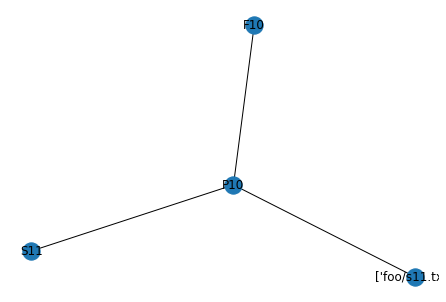

In [109]:
component = list(nx.connected_components(G))[0]
print(component)
nx.draw(G.subgraph(component), with_labels=True)

In [110]:
G = nx.Graph()
for df in data_files:
    new_df_to_graph(G, df)
    
family_dict = record_family(G)

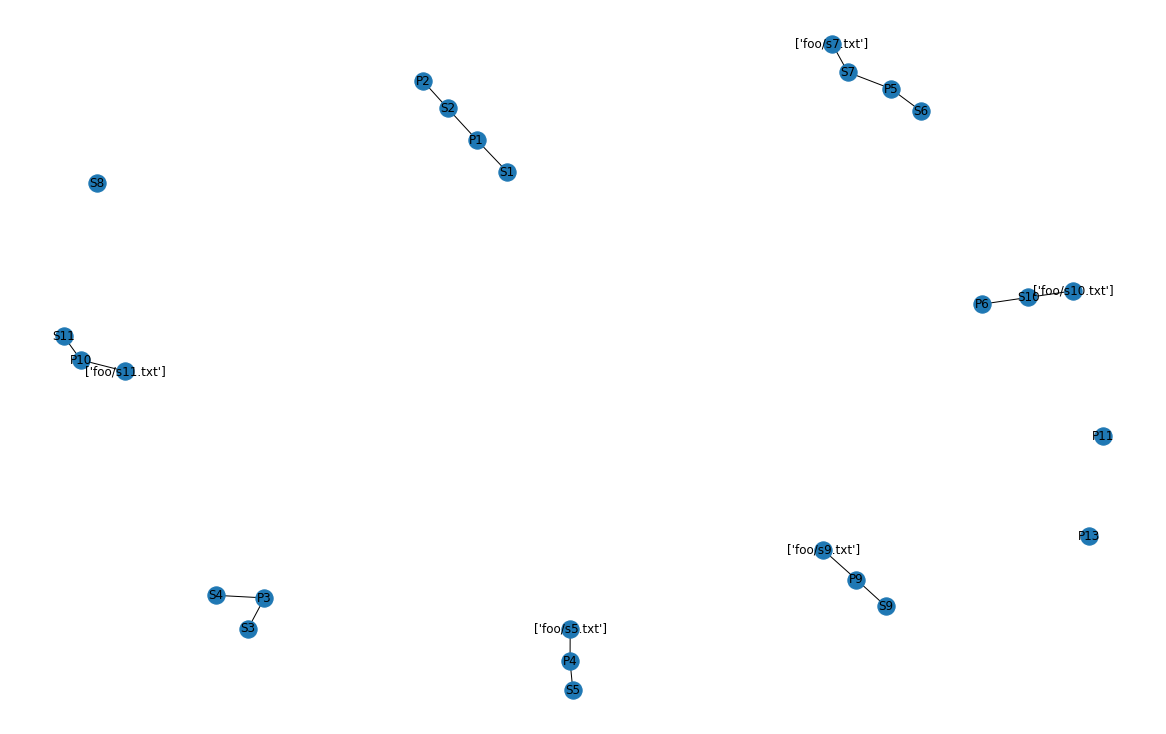

In [111]:
plt.figure(figsize=(16,10))
nx.draw(G, with_labels=True)

In [112]:
family_dict

{'F10': {'participants': ['P10'], 'file': 'data1/pf.csv'},
 'F12': {'participants': [], 'file': 'data1/pf.csv'},
 'F13': {'participants': ['P13'], 'file': 'data1/pf.csv'},
 'F2': {'participants': ['P5', 'P4'], 'file': 'data1/sfp2.csv'},
 'F9': {'participants': ['P9'], 'file': 'data1/spf.csv'},
 'F3': {'participants': ['P6'], 'file': 'data1/sfp2.csv'},
 'F1': {'participants': ['P3', 'P2', 'P1'], 'file': 'data1/sfp2.csv'}}

In [113]:
G.nodes['P3']['family']

['F1']

In [114]:
# Now process the family relationships, then prune the associated nodes to make the tests easier
# Things get weird if a participant is a member of more than one family (which is allowed). In order
# to handle this, we need to take each connected subcomponent and split them up further into connected
# subcomponents for each family unit. This can be done by iterating over the family ID nodes and deleting
# all other family ID nodes in the subcomponent.


In [115]:
def check_relationship_2(G):
    """
    Takes in a connected subgraph (which hopefully represents a single patient and their associated data),
    and checks for the 2nd relationship as defined in notion. This relationship is that a Specimen comes from 1
    Participant. Returns a bool representing this check.
    """
    subgraphs = list(nx.connected_components(G))
    for subgraph in subgraphs:
        for index in subgraph:
            node = G.nodes[index]
            # In order to differentiate between bad specimens and bad genomic files we need to examine each biospecimens edges
            num_parts = 0
            
            if node["type"] == "BIOSPECIMEN|ID":            
                for edge in G.edges(index):
                    if G.nodes[edge[1]]["type"] == "PARTICIPANT|ID":
                        num_parts += 1

                if num_parts > 1:
                    return False
    return True
            

In [116]:
def subgraph_counts(G):
    """
    Given graph G counts the number of each type of node in each connected sub-component.
    These counts can be used to easily perform the validation tests.
    """
    subgraphs = list(nx.connected_components(G))
    types = {}
    for subgraph in subgraphs:
        sub_dict = {
            "PARTICIPANT|ID": [],
            "GENOMIC_FILE|URL_LIST": [],
            "BIOSPECIMEN|ID": []
        }
        
        for index in subgraph:
            node = G.nodes[index]
            sub_dict[node["type"]].append(index)
            
        types[tuple(subgraph)] = sub_dict
            
    return types

In [117]:
types = subgraph_counts(G)
pprint(types)

{('P10', "['foo/s11.txt']", 'S11'): {'BIOSPECIMEN|ID': ['S11'],
                                     'GENOMIC_FILE|URL_LIST': ["['foo/s11.txt']"],
                                     'PARTICIPANT|ID': ['P10']},
 ('P11',): {'BIOSPECIMEN|ID': [],
            'GENOMIC_FILE|URL_LIST': [],
            'PARTICIPANT|ID': ['P11']},
 ('P13',): {'BIOSPECIMEN|ID': [],
            'GENOMIC_FILE|URL_LIST': [],
            'PARTICIPANT|ID': ['P13']},
 ('P2', 'S1', 'P1', 'S2'): {'BIOSPECIMEN|ID': ['S1', 'S2'],
                            'GENOMIC_FILE|URL_LIST': [],
                            'PARTICIPANT|ID': ['P2', 'P1']},
 ('P9', 'S9', "['foo/s9.txt']"): {'BIOSPECIMEN|ID': ['S9'],
                                  'GENOMIC_FILE|URL_LIST': ["['foo/s9.txt']"],
                                  'PARTICIPANT|ID': ['P9']},
 ('S10', 'P6', "['foo/s10.txt']"): {'BIOSPECIMEN|ID': ['S10'],
                                    'GENOMIC_FILE|URL_LIST': ["['foo/s10.txt']"],
                                   

In [118]:
def new_check_relationship_2(types):
    bad_biospecimens = []
    for component in types:
        if types[component]["BIOSPECIMEN|ID"]:
            if len(types[component]["PARTICIPANT|ID"]) != 1:
                bad_biospecimens.extend(types[component]["BIOSPECIMEN|ID"])
            
    return bad_biospecimens
        

In [119]:
new_check_relationship_2(types)

['S1', 'S2', 'S8']

In [120]:
def check_relationship_3(types):
    """
    A Participant is linked to at least 1 Specimen
    """
    bad_participants = []
    for component in types:
        if types[component]["PARTICIPANT|ID"]:
            if not types[component]["BIOSPECIMEN|ID"]:
                bad_participants.extend(types[component]["PARTICIPANT|ID"])
            
    return bad_participants

In [121]:
check_relationship_3(types)

['P11', 'P13']

In [122]:
def check_relationship_5(types):
    """
    A Source Seq File Manifest Record is linked to exactly 1 Specimen
    """
    bad_seq_files = []
    for component in types:
        if types[component]["GENOMIC_FILE|URL_LIST"]:
            if not types[component]["BIOSPECIMEN|ID"]:
                bad_seq_files.extend(types[component]["GENOMIC_FILE|URL_LIST"])
                
    return bad_seq_files
    

In [123]:
check_relationship_5(types)

[]

In [124]:
def check_relationship_7(G, types):
    """
    A Participant is in at least 1 Family Group
    """
    participants = [
        part
        for component in types
        for part in types[component]["PARTICIPANT|ID"]
    ]
    
    bad_parts = []
    for part in participants:
        if "family" not in G.nodes[part]:
            bad_parts.append(part)
            
    return bad_parts

In [125]:
check_relationship_7(G, types)

['P11']

In [68]:
G.nodes['P10']

{'type': 'PARTICIPANT|ID', 'family': 'F10'}

In [129]:
def check_relationship_8(family_dict):
    """
    A Family Group has at least 1 Participants
    """
    bad_families = []
    for family in family_dict:
        if not family_dict[family]["participants"]:
            bad_families.append(family)
            
    return bad_families
    
    

In [130]:
check_relationship_8(family_dict)

['F12']

In [ ]:
def test_validate(name, errors, condition = None):
    